In [75]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import scipy as sc
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import sklearn
import math
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
%matplotlib inline

In [76]:
def load_soup_object(link):
    link = requests.get(link,headers=0)
    soup = BeautifulSoup(link.content, "html.parser")
    return soup

In [5]:
Hotel_Name = []
Staff_Rating = []
Facilities_Rating = []
Cleanliness_Rating = []
Comfort_Rating = []
Value_For_Money_Rating = []
Location_Rating = []
Free_WiFi_Rating = []
Final_Grade = []


# accessing the class that contains the list of regions - not only in israel 
# and creating a list of known cities to be extracted 
# counter will be used to save the index of the desired regions - then to specify the index withing the 'searches' list



soup1 = load_soup_object(URL)
searches = soup1.find(class_="ia_section-container clearfix wcu-seo-regions-poi").find_all('a')
#searches is 
cities = ["אזור ירושלים","אזור המרכז","גליל","גליל עליון","כנרת","אזור תל אביב","דרום הארץ","ים המלח","נגב","צפון הארץ","רמת הגולן"]
names = []
indexes = []
href_list = []
counter = 0
for i in searches:
    name1 = i.get_text().replace("\n", "")
    if name1 in cities:
        names.append(name1)
        indexes.append(counter)
        href = searches[counter].get("href").strip()
        URL2=URL+href
        soup2=load_soup_object(URL2)
        
        
        
         # now that we have the full link to the specific region
        # lets parse it so we can inspect and work with each page 
        # each region`s page has a specific "Watch all" link that needs to be accessed
        # therefore, we are accessing the class that contains the only object(link) we need
        # and concatanating the link to the original URL
        
        searches2 = soup2.find(class_="lp-bui-section bui-spacer--largest x2").find_all("a")
        print("region is:", name1)
        nexthref = URL + searches2[0].get("href").strip()
        href_list.append(nexthref)
        print("href:\n", nexthref)
    counter+=1

region is: אזור ירושלים
href:
 https://www.booking.com/he/searchresults.he.html?label=gen173nr-1FCAEoggI46AdIDlgEaGqIAQGYAQ64AQrIAQXYAQHoAQH4AQ6IAgGoAgO4AqOsypQGwAIB0gIkYjliODZiZjItZjc5Yi00NzRjLWJhNWEtY2ZkZjU5N2Y1ZmQz2AIG4AIB&sid=1f1e9e17e45110c5b9dba0ff0cf51e3a&region=3637&
region is: צפון הארץ
href:
 https://www.booking.com/he/searchresults.he.html?label=gen173nr-1FCAEoggI46AdIDlgEaGqIAQGYAQ64AQrIAQXYAQHoAQH4AQ6IAgGoAgO4AqOsypQGwAIB0gIkYjliODZiZjItZjc5Yi00NzRjLWJhNWEtY2ZkZjU5N2Y1ZmQz2AIG4AIB&sid=e9d633f6994ed02164d435791619f056&region=3638&
region is: אזור המרכז
href:
 https://www.booking.com/he/searchresults.he.html?label=gen173nr-1FCAEoggI46AdIDlgEaGqIAQGYAQ64AQrIAQXYAQHoAQH4AQ6IAgGoAgO4AqOsypQGwAIB0gIkYjliODZiZjItZjc5Yi00NzRjLWJhNWEtY2ZkZjU5N2Y1ZmQz2AIG4AIB&sid=2a57d5e2657f40d29686bec04723b27a&region=3640&
region is: גליל
href:
 https://www.booking.com/he/searchresults.he.html?label=gen173nr-1FCAEoggI46AdIDlgEaGqIAQGYAQ64AQrIAQXYAQHoAQH4AQ6IAgGoAgO4AqOsypQGwAIB0gIkYjliODZiZjItZjc5

In [ ]:
# in the next block we will define the function that will adjust links
# to help us move between pages inside our website
# url_num : is the variable responsible to indicate which page we are going to display (1st page = 25, 2nd page = 50...)
# url_num_flag : is the variable that we will use to know how to "cut" the link string i.e after 3 iterations 
#                                    we will have the number 100 so we need to cut 3 digits instead of 5
# offset_flag : is the variable that will indicate whether the 1st page`s link ends with &offset=25 OR just &
# region counter is not critical to the code - just counting how many links starting with "offset"
# using global keyword to be able to update values that exist outside of the funtion 

def adjust_link():
    global link
    global url_num
    global offset_flag
    global url_num_flag
    global region_counter
    if offset_flag == 0: # flag == 0 ---> // first page is link is : https://dfsdfs&offset=25
            region_counter += 1
            print("with offset for link is : ", link)
            print("url flag is : ", url_num_flag)
            if url_num_flag >= 39:
                link = link[:-4]
                link += str(url_num)
                url_num += 25

            elif url_num_flag >= 3:
                link = link[:-3]
                link += str(url_num)
                url_num += 25

            else:
                link = link[:-2]
                link += str(url_num)
                url_num += 25

    else: # flag == 1 ---> // first page is link is : https://dfsdfs&
        region_counter -= 1
        link += "offset=25"
        offset_flag = 0
        url_num += 25
    url_num_flag += 1
    return link

In [20]:
# now that we have all the links to all regions(north, negev etc.),
# we need to parse each one with html.parser so we can work with it
counter2 = 0
region_counter = 0 # will count how many regions are starting with offset
for link in href_list: #i.e north, south, negev
    
    # url_num_flag will tell us how do we need to cut the link to adjust it for next pages
    # url_num will be the indicator for which page we want to fetch --> 1st page will be 25, 2nd will be 50....
    url_num_flag = 0
    url_num = 50
    #some pages links starts with an "offset" after the last & in the link, and some not, we need to check this with flag
    offset_flag = 0
    if link[-1] == "&":
        offset_flag = 1
        url_num_flag -= 1
        url_num -= 25
    # PRINTING FOR CHECK print("prime link is : ", link)
    city_soup = load_soup_object(link)
    number_of_pages = int(city_soup.find(class_="d493c719bc").find_all('li')[-1].get_text())
    for i in range(number_of_pages-1):
        # PRINTING FOR CHECK print("page is : ", i+1)
        # PRINTING FOR CHECK print("page link is : ", link)
        city_soup2 = load_soup_object(link)
        
        # find all links(names links) for all hotels in the page into a list.
        try:
            hotels = city_soup2.find(class_="d4924c9e74").find_all('h3')
        except:
            adjust_link()
            continue
        # PRINTING FOR CHECK print("len hotels : ", len(hotels))
        
        # now we start extracting information for the dataframe. we start by taking the hotel names into the hotel name list
        for item in hotels: # looping through the h3 class for the hotels --- item == href of single hotel
            # PRINTING FOR CHECK print("current hotel is in page : ", i+1)
            # flag will indicate if our 7 parameters exist 
            flag = 0
            # PRINTING FOR CHECK print("hotel : ",item.a.find(class_="fcab3ed991 a23c043802").get_text())
            hotel_eng_name = ""
            
            #if the hotel name is in hebrew - we will now fetch the english name for it - straight from the URL
            # because the hotel name starts after the 33rd character in the URL
            item_for_name = item.a.get("href").strip()[33:]
            for s in item_for_name:
                if s == ".":
                    break
                hotel_eng_name += s
            Hotel_Name.append(hotel_eng_name)
            # PRINTING FOR CHECK print("hotel in english : ", hotel_eng_name)
            # PRINTING FOR CHECK print("hotel link is :",item.a.get("href").strip())
            hotel_soup = load_soup_object(item.a.get("href").strip()) #loading the soup object of single hotel link
            
            # the grade of the hotel is in a seperate place from other parameters - lets extract the final grade.
            try:
                hotel_grade = hotel_soup.find('div',
                                   attrs={"class" : "a1b3f50dcd b2fe1a41c3 a1f3ecff04 db7f07f643 d19ba76520 f4e25490ec"})
                hotel_grade2 = hotel_grade.find(class_="b5cd09854e d10a6220b4").get_text()
            except:
                hotel_grade2 = 0
            Final_Grade.append(hotel_grade2)

            #now lets get inside the link of the current hotel - and fetch the information for our DataFrame
            hotel_props = hotel_soup.select(".v2_review-scores__body.v2_review-scores__body--compared_to_average li")
            hotel_props2 = hotel_props[14:]
            # PRINTING FOR CHECK print("hotel props len is : ", len(hotel_props2))
            
            # next block will check for errors in the data we want to scrape, in case of an error or missing data
            # we will fill the values with 0.
            # flag = 1 will indicate that our hotel has missing data.
            if (len(hotel_props2)) < 7:
                # PRINTING FOR CHECK print("problem in hotel : ", Hotel_Name[counter2])
                # PRINTING FOR CHECK print("hotel props : ", hotel_props2)
                flag = 1
            if flag == 1:
                Staff_Rating.append(0)
                Facilities_Rating.append(0)
                Cleanliness_Rating.append(0)
                Comfort_Rating.append(0)
                Value_For_Money_Rating.append(0)
                Location_Rating.append(0)
                Free_WiFi_Rating.append(0)
            else:
                Staff_Rating.append(hotel_props2[0].find(class_="c-score-bar__score").get_text())
                Facilities_Rating.append(hotel_props2[1].find(class_="c-score-bar__score").get_text())
                Cleanliness_Rating.append(hotel_props2[2].find(class_="c-score-bar__score").get_text())
                Comfort_Rating.append(hotel_props2[3].find(class_="c-score-bar__score").get_text())
                Value_For_Money_Rating.append(hotel_props2[4].find(class_="c-score-bar__score").get_text())
                Location_Rating.append(hotel_props2[5].find(class_="c-score-bar__score").get_text())
                Free_WiFi_Rating.append(hotel_props2[6].find(class_="c-score-bar__score").get_text())
        adjust_link()

    
dfdict = {"Hotel_Names":Hotel_Name,"Staff_Rating":Staff_Rating, "Facilities_Rating":Facilities_Rating, "Cleanliness_Rating":Cleanliness_Rating, "Comfort_Rating":Comfort_Rating, "Value_For_Money_Rating":Value_For_Money_Rating, "Location_Rating":Location_Rating, "Free_WiFi_Rating":Free_WiFi_Rating, "Final_Grade":Final_Grade}
df = pd.DataFrame(data=dfdict)
df.to_csv('./BookingHotels.csv')
df.style

len hotels :  25
hi2
hotel :  Desert chilling - סתלבט במדבר
hotel in english :  stlbt-bmdbr
link is : https://www.booking.com/hotel/il/stlbt-bmdbr.he.html?label=gen173nr-1FCAEoggI46AdIDlgEaGqIAQGYAQ64AQrIAQXYAQHoAQH4AQ6IAgGoAgO4Avj2lJQGwAIB0gIkZmUxZGY3NTUtOTJiMy00MzcyLWJkYzEtY2ZiYzZmYWIxMWY52AIG4AIB&sid=e50b33a8d1d2d0c30beee9bf772a05ea&aid=304142&ucfs=1&arphpl=1&dest_id=3230&dest_type=region&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=1&sr_order=popularity&srpvid=cfd3848111860268&srepoch=1652899843&from=searchresults#hotelTmpl
hotel props len is :  7
Hotel_Names: 30 
 ['xxxx-xc-x-xx', 'the-green-guesthouse', 'dead-sea-club-guest-house', 'zimer-dora', 'leonardo-plaza-dead-sea', 'lesanel-guest-house', 'dead-sea-yehuda-apartments', 'khvvh-ykhydt-yrvkh', 'oasis-spa-club-dead-sea-hotel', 'isrotel-dead-sea', 'new-the-luxe-suite-in-arad', 'dy-bmdbr', 'rom-hatayelet', 'vastu-dead-sea-apartment', 'sweet-home-rd', 'guest-house-tzimer-lana', 'belfer-s-dead-

hotel props len is :  7


TypeError: 'str' object is not callable

In [18]:
df.style

,Staff_Rating,Facilities_Rating,Cleanliness_Rating,Comfort_Rate,Value_For_Money_Rate,Location_Rate,Free_WiFi_Rating,Hotel_Names
0,8.5,6.6,7.7,7.6,7.1,8.3,7.6,xxxx-xc-x-xx
1,9.6,8.9,9.6,9.2,8.7,9.4,9.3,the-green-guesthouse
2,9.5,9.4,9.6,9.2,9.3,8.9,8.8,dead-sea-club-guest-house
3,8.1,7.6,8.0,7.7,7.8,8.0,9.0,zimer-dora
4,8.3,8.0,8.1,8.2,7.2,8.7,7.7,leonardo-plaza-dead-sea
5,8.4,8.2,8.9,8.3,8.0,8.4,10,lesanel-guest-house
6,0,0,0,0,0,0,0,dead-sea-yehuda-apartments
7,9.9,9.4,9.5,9.4,9.3,9.2,9.7,khvvh-ykhydt-yrvkh
8,8.0,7.6,7.7,7.8,7.1,8.6,7.5,oasis-spa-club-dead-sea-hotel
9,8.3,8.4,8.5,8.5,7.5,8.8,8.7,isrotel-dead-sea


In [185]:
df = pd.read_csv('BookingHotels.csv', header=0,index_col=0)

In [186]:
df.Staff_Rating.describe()

count    8000.000000
mean        4.797625
std         4.547680
min         0.000000
25%         0.000000
50%         7.500000
75%         9.300000
max        10.000000
Name: Staff_Rating, dtype: float64

In [187]:
df.head()

,Hotel_Names,Staff_Rating,Facilities_Rating,Cleanliness_Rating,Comfort_Rating,Value_For_Money_Rating,Location_Rating,Free_WiFi_Rating,Final_Grade
0,desert-view,9.4,9.0,8.9,9.2,9.0,9.1,9.2,8.9
1,eretz-zeelim,8.4,7.8,7.8,7.7,7.2,8.1,4.6,7.6
2,kibbutz-lotan-ecotourism,9.3,8.0,8.6,8.3,8.4,9.0,7.8,8.3
3,desert-iris,8.3,7.6,7.6,8.1,7.4,8.3,7.3,7.7
4,amazing-bedouin-hospitality,9.8,8.9,9.2,9.0,9.3,8.6,9.1,9.2


In [188]:
df2 = df.iloc[:].copy()
df2.shape

(8000, 9)

In [189]:
# in this code block we will handle our data inside our DataFrame that is incompatibe with our desired data.
# first we will remove all missing data indicated by values of 0.0
# after that we will drop dupliacted rows and we can simply check that by checking if the Hotel Name appear more than once
# after that we will reset the indexes 
df2 = df[df.Comfort_Rating != 0.0]
df2 = df2.drop_duplicates(subset=['Hotel_Names'])
df2.reset_index(drop=True, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hotel_Names             1978 non-null   object 
 1   Staff_Rating            1978 non-null   float64
 2   Facilities_Rating       1978 non-null   float64
 3   Cleanliness_Rating      1978 non-null   float64
 4   Comfort_Rating          1978 non-null   float64
 5   Value_For_Money_Rating  1978 non-null   float64
 6   Location_Rating         1978 non-null   float64
 7   Free_WiFi_Rating        1978 non-null   float64
 8   Final_Grade             1978 non-null   float64
dtypes: float64(8), object(1)
memory usage: 139.2+ KB


In [190]:
# in this code block we will handle our data inside our DataFrame that is incompatibe with our desired data.
# first we will remove all missing data indicated by values of 0.0
# after that we will drop dupliacted rows and we can simply check that by checking if the Hotel Name appear more than once
# after that we will reset the indexes 
df2 = df[df.Comfort_Rating != 0.0]
df2 = df2.drop_duplicates(subset=['Hotel_Names'])
df2.reset_index(drop=True, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hotel_Names             1978 non-null   object 
 1   Staff_Rating            1978 non-null   float64
 2   Facilities_Rating       1978 non-null   float64
 3   Cleanliness_Rating      1978 non-null   float64
 4   Comfort_Rating          1978 non-null   float64
 5   Value_For_Money_Rating  1978 non-null   float64
 6   Location_Rating         1978 non-null   float64
 7   Free_WiFi_Rating        1978 non-null   float64
 8   Final_Grade             1978 non-null   float64
dtypes: float64(8), object(1)
memory usage: 139.2+ KB


In [191]:
df2

,Hotel_Names,Staff_Rating,Facilities_Rating,Cleanliness_Rating,Comfort_Rating,Value_For_Money_Rating,Location_Rating,Free_WiFi_Rating,Final_Grade
0,desert-view,9.4,9.0,8.9,9.2,9.0,9.1,9.2,8.9
1,eretz-zeelim,8.4,7.8,7.8,7.7,7.2,8.1,4.6,7.6
2,kibbutz-lotan-ecotourism,9.3,8.0,8.6,8.3,8.4,9.0,7.8,8.3
3,desert-iris,8.3,7.6,7.6,8.1,7.4,8.3,7.3,7.7
4,amazing-bedouin-hospitality,9.8,8.9,9.2,9.0,9.3,8.6,9.1,9.2
...,...,...,...,...,...,...,...,...,...
1973,yrvkh-trshysh,9.3,8.9,9.1,9.1,9.2,8.8,8.8,8.9
1974,gili-s-guest-rooms,8.9,8.1,8.6,8.4,7.6,8.4,9.6,8.2
1975,tspym-l-hym,9.1,8.5,8.8,8.5,8.1,8.1,5.8,8.4
1976,guest-house-neve-zohar-dead-sea,8.0,7.4,7.7,7.7,7.6,8.7,7.5,7.3


In [192]:
def one_dim_plot(sr, plot_type, axis):
    if plot_type == "bar":
        axis.bar(x = sr.index, height = sr.values)
    elif plot_type == "pie":
        axis.pie(x = sr.values, labels = sr.index)
    else:
        axis.plot(sr.index, sr.values)

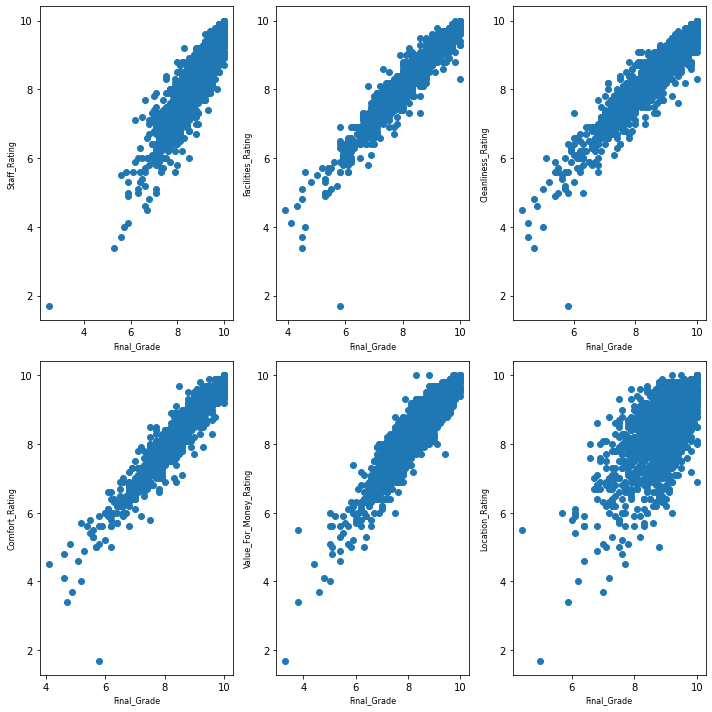

In [193]:
for i in range(1,7):
    firstcol = df.columns[i] # Location_Rating
    plt.subplot(2, 3, i)
    plt.gcf().set_size_inches((10, 10)) 
    plt.scatter(df2[firstcol], df2.Final_Grade)
    plt.ylabel(df2.columns[i],fontsize = 8)
    plt.xlabel('Final_Grade',fontsize = 8)
    
    
plt.tight_layout()

In [194]:
# this function will serve us for replacing values in the column "Free_WiFi_Rating"
# first we will get the median value of the column and call this variable m
# we will replace all values that are greater than m to 1
# we will replace all values that are lower than m to 0
def value_to_binary(x):
    global m
    if x > m:
        return int(1)
    else:
        return int(0)

In [195]:
# assigning the value m with the median value of the column "Free_WiFi_Rating"
# using apply function to update our column values to 0 or 1 
m = df2['Free_WiFi_Rating'].mean()
df2["Free_WiFi_Rating"] = df2["Free_WiFi_Rating"].apply(value_to_binary)
df2.head()

,Hotel_Names,Staff_Rating,Facilities_Rating,Cleanliness_Rating,Comfort_Rating,Value_For_Money_Rating,Location_Rating,Free_WiFi_Rating,Final_Grade
0,desert-view,9.4,9.0,8.9,9.2,9.0,9.1,1,8.9
1,eretz-zeelim,8.4,7.8,7.8,7.7,7.2,8.1,0,7.6
2,kibbutz-lotan-ecotourism,9.3,8.0,8.6,8.3,8.4,9.0,0,8.3
3,desert-iris,8.3,7.6,7.6,8.1,7.4,8.3,0,7.7
4,amazing-bedouin-hospitality,9.8,8.9,9.2,9.0,9.3,8.6,1,9.2


In [196]:
df2["Free_WiFi_Rating"].value_counts()

1    1155
0     823
Name: Free_WiFi_Rating, dtype: int64

<AxesSubplot:ylabel='Free_WiFi_Rating'>

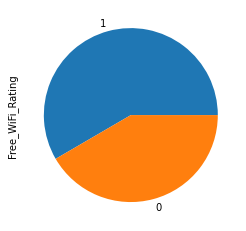

In [197]:
df2["Free_WiFi_Rating"].value_counts().plot(kind='pie')

In [198]:
#Plotting all the subplots
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(df2.Facilities_Rating, df2.Final_Grade)
axes[0, 1].plot(df2.Cleanliness_Rating, df2.Final_Grade,color="pink")
axes[0, 2].plot(df2.Comfort_Rating,df2.Final_Gradecolor="black")
axes[1, 0].plot(df2.Value_For_Money_Rating, df2.Final_Grade, color='yellow')
axes[1, 1].plot(df2.Staff_Rating, df2.Final_Grade, color='gray')
axes[1, 2].plot(df2.Location_Rating ,df2.Final_Grade, color='green',)
plt.tight_layout()

plt.show()

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (Temp/ipykernel_12936/616951835.py, line 5)

In [199]:
df_copy_learn=df2[["Staff_Rating","Facilities_Rating","Cleanliness_Rating","Comfort_Rating","Value_For_Money_Rating","Location_Rating","Free_WiFi_Rating","Final_Grade"]].copy()
df_copy_learn.head()

x = df_copy_learn[TRAINING_FEATURES] #matrix X of all the features (Staff_Rating,Facilities_Rating.....)
y = df_copy_learn[TARGET_FEATURE] # vector y (label) shows only Final_Grade (Our prediction)

# The train test method is used to split our data in such way that most values are used to train the model
# and saves a small portion of the data to test what the model "learned"
# we will be using 75% of the data to train the model, and the test size will be 25% of the data.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1483, 7) (1483,)
(495, 7) (495,)


In [200]:
lrm = linear_model.LinearRegression()
lrm_model = lrm.fit(x_train, y_train)
lrm_predictions = lrm.predict(x_test)

In [201]:
lrm_predictions

array([8.69065436, 8.31784777, 6.81465055, 9.02642673, 8.94542506,
       9.2451838 , 8.09043574, 7.55011017, 6.41296444, 8.84547488,
       9.52434947, 9.4508775 , 9.35925357, 7.93001186, 6.02611357,
       9.00983202, 9.06562086, 8.96648763, 9.6510633 , 8.32251785,
       7.02656754, 6.70379572, 7.32362452, 8.04969436, 9.47339914,
       8.73082134, 8.74657125, 8.16421431, 6.40819067, 8.84324824,
       7.05214343, 8.6329796 , 6.05397491, 8.55472955, 8.94092215,
       8.16416135, 6.77407928, 8.91213771, 9.47304847, 9.85873569,
       8.78207076, 9.60501064, 7.40698311, 8.92519413, 9.17806782,
       7.72549193, 9.40105986, 9.08811468, 8.25160104, 9.16570937,
       9.74214357, 8.91294354, 6.59553004, 8.45917055, 9.19830394,
       6.44281732, 8.2513312 , 7.65435093, 9.32535824, 8.42935995,
       9.10599376, 7.39598956, 6.34954619, 8.75937311, 8.68935037,
       9.76197508, 7.59226434, 9.12369981, 6.72139726, 8.16537734,
       8.52383096, 9.11496227, 9.59080026, 8.55162556, 9.13347

In [202]:
print("Score: ", lrm_model.score(x_test, y_test))

Score:  0.9614114721171659


In [203]:
Preditions_VS_Actual = pd.DataFrame(x_test)
Preditions_VS_Actual['Actual_Grade'] = y_test
Preditions_VS_Actual['Predicted_Grade'] = lrm_predictions
Preditions_VS_Actual

,Staff_Rating,Facilities_Rating,Cleanliness_Rating,Comfort_Rating,Value_For_Money_Rating,Location_Rating,Free_WiFi_Rating,Actual_Grade,Predicted_Grade
1027,9.4,8.5,9.4,8.6,8.5,8.8,1,9.0,8.690654
1425,9.0,8.0,8.6,8.4,8.1,9.3,1,8.2,8.317848
943,7.1,6.9,7.5,7.4,6.8,7.4,0,7.0,6.814651
1012,9.2,8.9,9.2,9.3,8.7,9.8,0,9.0,9.026427
1718,9.6,8.8,8.8,9.0,8.9,9.4,0,8.9,8.945425
...,...,...,...,...,...,...,...,...,...
387,9.2,9.2,8.8,9.2,8.8,9.2,0,9.1,8.979673
377,10.0,9.5,9.8,9.8,9.5,8.4,1,9.7,9.519203
1582,9.0,8.5,9.2,9.0,8.0,8.9,0,8.6,8.595630
921,8.0,7.1,7.8,7.7,7.1,8.9,0,7.5,7.386949


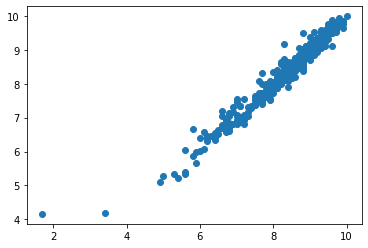

In [207]:
plt.scatter(y_test,lrm_predictions)

In [208]:
reg=np.polyfit(y_test,lrm_predictions,deg=1)
reg

array([0.93758478, 0.5408839 ])

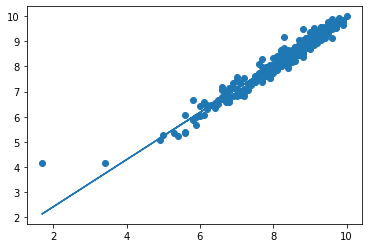

In [209]:
trend = np.polyval(reg,y_test)
plt.scatter(y_test,lrm_predictions)
plt.plot(y_test,trend)